![title](bw.JPG)

# Problem Statement

** A financial institution news agency has collected 3000 news articles that relates to several matters of financial importance. Before analyzing these unlabeled news, it is only fair to try to partition them into some sort of logical groupings based on their similarities.**

**Your task is to use appropriate unsupervised machine learning algorithm to form the news clusters based on their similarity. Prior to clustering it is recommended to perform basic natural language processing steps such as stemming, tokenization and word vectorization for best results.  **

Notes to keep in mind:

There are no duplicate rows in the dataset.

Cluster number should start from 0.

### Data Description
There is only one file news.csv that contains date, headlines and text of the news.

|Column|Description|
|------|------|
|id|The unique id of the news|
|headline|The headline of the news in text|
|text|The body of the news in text|


### Submission
The submission file should be a zip containing a .txt and .csv file. Both should have 3000 rows.

.txt file should contain the matrix / ndarrays you are using to create clusters.
.csv should contain the cluster of customers against every store.
Format of the csv file:

|id|cluster|
|------|------|
|uid-1|0|
|uid-2|0|
|uid-3|1|
|uid-4|1|
|uid-5|4|

### Evaluation Metric
The submissions will be evaluated on silhouette score. Please read more about the metrics here.

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
%matplotlib inline
import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [5]:
data1=pd.read_csv('news.csv')
data1.head()

,id,headline,text
0,uid-1,Market Advances 5.12 More,NEW YORK (AP) - A prime rate reduction by New ...
1,uid-2,District Boosts Request For Anti-Terrorism Aid...,Mayor Anthony A. Williams petitioned the White...
2,uid-3,"Election? Here's How You Do It, Mate.",From our downunder perspective here in Austral...
3,uid-4,The Biggest Boom Ever,We are about to rewrite history. Unless a rece...
4,uid-5,Economic Aide Sees Uptrend,"Sedate and scholarly Dr. Arthur Burns, the ex-..."


## Data Cleaning

In [6]:
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
def url_to_words(raw_text):
    raw_text=BeautifulSoup(raw_text).text
    raw_text=raw_text.strip()
    
    no_coms=re.sub(r'\.com','',raw_text)
    no_urls=re.sub('https?://www','',no_coms)
    no_urls1=re.sub('https?://','',no_urls)
    try:
        no_encoding=no_urls1.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        no_encoding = no_urls1
    letters_only = re.sub("[^a-zA-Z]", " ",no_encoding) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    meaningful_words1=[stemmer.stem(word) for word in meaningful_words]
#     meaningful_words1=[w for w in meaningful_words if w in tot_tagss]
    return( " ".join( meaningful_words1 )) 

In [7]:
data=data1.copy()
data['headline']=data['headline'].apply(url_to_words)
data['text']=data['text'].apply(url_to_words)

C:\Users\Acer\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Acer\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [8]:
data['total']=data['headline']+data['text']

###  Tf-id vectors

In [9]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vec_head = TfidfVectorizer(ngram_range=(1,100),stop_words="english", analyzer='word')
headline =vec_head.fit_transform(data1['headline'])

# cvec_head = CountVectorizer(ngram_range=(1,10),stop_words="english", analyzer='word',max_df=0.95)
# headline2 =cvec_head.fit_transform(data['headline'])@

# vec_head1 = TfidfVectorizer(ngram_range=(1,7),stop_words="english", analyzer='word',max_df=0.95)
# headline1 =vec_head1.fit_transform(data['headline'])

vec_headchar = TfidfVectorizer(ngram_range=(1,100),stop_words="english", analyzer='char')
headlineChar =vec_headchar.fit_transform(data1['headline'])

# vec_text = TfidfVectorizer(ngram_range=(1,4),stop_words="english", analyzer='word')
# text =vec_text.fit_transform(data['text'])

# vec_textCHar = TfidfVectorizer(ngram_range=(1,6),stop_words="english", analyzer='char')
# textChar =vec_textCHar.fit_transform(data['text'])

# vec_total = TfidfVectorizer(ngram_range=(1,3),stop_words="english", analyzer='word')
# total =vec_total.fit_transform(data['total'])

# vec_totalchar = TfidfVectorizer(ngram_range=(1,6),stop_words="english", analyzer='char')
# totalchar =vec_totalchar.fit_transform(data['total'])

In [10]:
from scipy.sparse import csr_matrix
from scipy import sparse
#best was headline, text and headline char with 2-2
feat = sparse.hstack((headlineChar,headline)).tocsr()
feat

<3000x5867872 sparse matrix of type '<class 'numpy.float64'>'
	with 6845383 stored elements in Compressed Sparse Row format>

### Decomposition

In [11]:
from sklearn.decomposition import PCA,TruncatedSVD,FastICA,SparsePCA
pca=TruncatedSVD(n_components=2,n_iter=10,random_state=1994)
pca_feat=pca.fit_transform(headline)

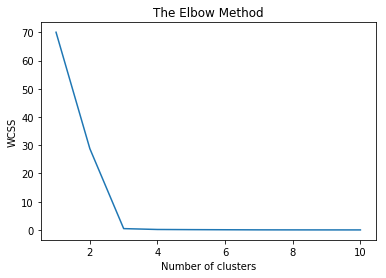

In [12]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=1994)
    kmeans.fit(pca_feat)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.savefig('elbow.png')
plt.show()

* **Taking best number of clusters from elbow method**
* **Only headline seems to confine with the best number of vectors possible**

In [13]:
from sklearn.cluster import KMeans,AgglomerativeClustering
km=KMeans(n_clusters=3,random_state=1994)
p=km.fit_predict(pca_feat)

# ag=AgglomerativeClustering(n_clusters=4)
# p=ag.fit_predict(pca_feat)

### Evaluation

In [14]:
from sklearn.metrics import silhouette_score
silhouette_score(pca_feat,p)

0.9965101160347276

In [15]:
s=pd.DataFrame({'id':data.id,'cluster':p})
s.head()

,id,cluster
0,uid-1,0
1,uid-2,0
2,uid-3,0
3,uid-4,0
4,uid-5,0


In [ ]:
s.to_csv('c6.csv',index=False)
np.savetxt("arrayPCAc6.txt",pca_feat)